# 04 — Community Detection (CV–Job Graph)

## Objectif
Détecter des communautés (groupes) dans le graphe biparti CV–Job.

Comme les méthodes classiques (Louvain, Leiden) s’appliquent surtout sur des graphes "unipartites",
on utilise une **projection** :

- Projection **CV–CV** : deux CV sont liés s’ils partagent des Jobs (poids = nombre de Jobs partagés)
- (Optionnel) Projection **Job–Job** : deux Jobs sont liés s’ils partagent des CV

Ensuite, on applique **Louvain** pour obtenir un label de communauté pour chaque CV (ou Job).

## Sorties
- `results/cv_with_communities.csv`
- (optionnel) `results/job_with_communities.csv`
- Statistiques : nombre de communautés, tailles, etc.
- Visualisation échantillon
- Interprétation sémantique rapide (top skills / mots par communauté)

In [1]:
import os
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

plt.rcParams["figure.figsize"] = (7, 4)

In [2]:
try:
    import community as community_louvain
    print("✅ python-louvain already available")
except ModuleNotFoundError:
    !pip -q install python-louvain
    import community as community_louvain
    print("✅ Installed python-louvain")

✅ python-louvain already available


In [3]:
G = nx.read_graphml("results/graph_bipartite.graphml")
cv = pd.read_csv("data/processed/cv_clean.csv")
job = pd.read_csv("data/processed/job_clean.csv")

print("Graph:", G.number_of_nodes(), "nodes |", G.number_of_edges(), "edges")
print("cv:", cv.shape, "| job:", job.shape)

Graph: 390 nodes | 1200 edges
cv: (300, 6) | job: (90, 5)


## 3) Projection CV–CV

Chaque arête (CV_i, CV_j) est pondérée par le nombre de Jobs partagés.
Cette projection capture une similarité structurelle entre CV.

In [4]:
cv_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "cv"]
cv_proj = bipartite.weighted_projected_graph(G, cv_nodes)

print("CV projection:", cv_proj.number_of_nodes(), "nodes |", cv_proj.number_of_edges(), "edges")


CV projection: 300 nodes | 7196 edges


## 4) Détection de communautés (Louvain)

Louvain maximise la modularité et retourne un label de communauté pour chaque nœud de la projection.

In [6]:
!pip uninstall -y community

Found existing installation: community 1.0.0b1
Uninstalling community-1.0.0b1:
  Successfully uninstalled community-1.0.0b1


In [7]:
!pip install python-louvain

In [8]:
import community.community_louvain as community_louvain
partition = community_louvain.best_partition(cv_proj, weight="weight", random_state=42)

comm = pd.Series(partition, name="community_id").astype(int)
print("Nombre de communautés:", comm.nunique())

comm.value_counts().head(10)

Nombre de communautés: 7


,count
community_id,
3,60
6,50
5,49
0,46
1,37
2,36
4,22


## 5) Ajouter `community_id` dans la table CV

On enrichit `cv_clean.csv` avec la communauté détectée.

In [9]:
cv_comm = comm.rename_axis("cv_id").reset_index()
cv_with_comm = cv.merge(cv_comm, on="cv_id", how="left")

display(cv_with_comm.head(5))

os.makedirs("results", exist_ok=True)
out_path = "results/cv_with_communities.csv"
cv_with_comm.to_csv(out_path, index=False)

print("✅ Saved:", out_path)

,cv_id,clean_text,level,profile_type,domain,skills_norm_str,community_id
0,CV_0000,cv profile junior candidate in design experien...,junior,polyvalent,design,"linux, javascript, scrum, git, python, budgeti...",1
1,CV_0001,cv profile intermediate candidate in design ex...,intermediate,specialized,design,"typography, design systems, adobe photoshop, u...",2
2,CV_0002,cv profile junior candidate in management expe...,junior,specialized,management,"agile, scrum, budgeting, communication, planni...",6
3,CV_0003,cv profile junior candidate in finance experie...,junior,specialized,finance,"powerpoint, forecasting, financial modeling, e...",4
4,CV_0004,cv profile senior candidate in data experience...,senior,polyvalent,data,"risk analysis, leadership, project management,...",6


✅ Saved: results/cv_with_communities.csv


## 6) Statistiques sur les communautés

On regarde :
- tailles des communautés
- top communautés

,count
community_id,
3,60
6,50
5,49
0,46
1,37
2,36
4,22


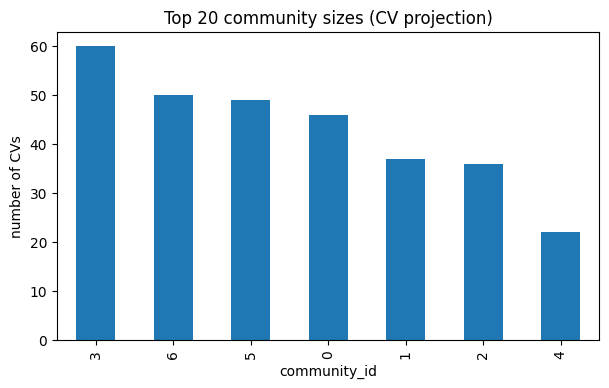

In [10]:
sizes = cv_with_comm["community_id"].value_counts().sort_values(ascending=False)
display(sizes.head(10))

plt.figure()
sizes.head(20).plot(kind="bar")
plt.title("Top 20 community sizes (CV projection)")
plt.xlabel("community_id")
plt.ylabel("number of CVs")
plt.show()

## 7) Visualisation (échantillon) des communautés

On prend un échantillon de nœuds pour visualiser la structure.
(Le graphe complet peut être trop dense.)

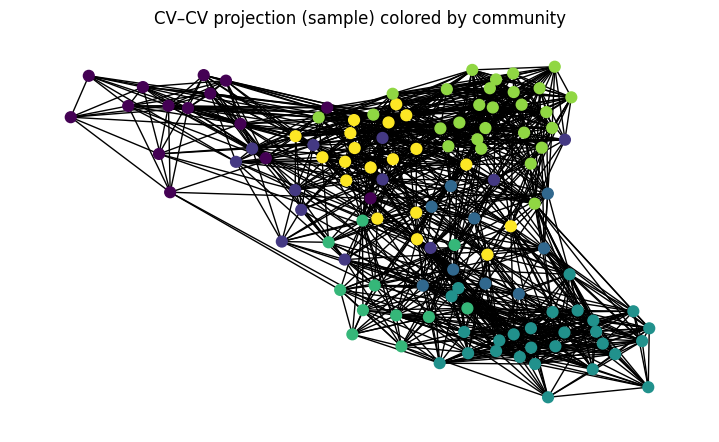

In [11]:
import random
random.seed(42)

sample_nodes = random.sample(list(cv_proj.nodes()), k=min(120, cv_proj.number_of_nodes()))
H = cv_proj.subgraph(sample_nodes).copy()

pos = nx.spring_layout(H, seed=42)

# Map community to integer colors
node_colors = [partition.get(n, -1) for n in H.nodes()]

plt.figure()
nx.draw(H, pos, with_labels=False, node_size=60, node_color=node_colors)
plt.title("CV–CV projection (sample) colored by community")
plt.show()

In [12]:
from collections import Counter

if "skills_norm_str" not in cv_with_comm.columns:
    print("⚠️ Column `skills_norm_str` not found. Skipping skill-based interpretation.")
else:
    def parse_skills(s):
        if pd.isna(s) or str(s).strip() == "":
            return []
        return [x.strip() for x in str(s).split(",") if x.strip()]

    # Pick top communities to interpret
    top_comms = sizes.head(5).index.tolist()

    for c_id in top_comms:
        subset = cv_with_comm[cv_with_comm["community_id"] == c_id]
        all_skills = []
        for s in subset["skills_norm_str"].tolist():
            all_skills += parse_skills(s)

        counter = Counter(all_skills)
        print(f"\nCommunity {c_id} | size={len(subset)}")
        print("Top skills:", counter.most_common(10))


Community 3 | size=60
Top skills: [('statistics', 37), ('data visualization', 35), ('sql', 34), ('python', 33), ('machine learning', 33), ('etl', 33), ('power bi', 32), ('tableau', 32), ('numpy', 31), ('pandas', 31)]

Community 6 | size=50
Top skills: [('communication', 42), ('agile', 38), ('budgeting', 35), ('project management', 34), ('stakeholder management', 34), ('planning', 33), ('scrum', 31), ('leadership', 31), ('presentation', 20), ('problem solving', 15)]

Community 5 | size=49
Top skills: [('linux', 33), ('cryptography', 32), ('risk assessment', 31), ('network security', 30), ('penetration testing', 29), ('incident response', 27), ('firewalls', 27), ('siem', 25), ('teamwork', 19), ('reporting', 18)]

Community 0 | size=46
Top skills: [('google analytics', 39), ('seo', 37), ('content marketing', 35), ('email marketing', 34), ('social media', 34), ('copywriting', 33), ('crm', 32), ('branding', 29), ('problem solving', 16), ('teamwork', 16)]

Community 1 | size=37
Top skills: 

##9) Communautés côté Job

Même approche sur la projection Job–Job : deux Jobs sont liés s’ils partagent des CV.
Cela peut révéler des groupes d’offres similaires.

In [13]:
job_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "job"]
job_proj = bipartite.weighted_projected_graph(G, job_nodes)

print("Job projection:", job_proj.number_of_nodes(), "nodes |", job_proj.number_of_edges(), "edges")

job_partition = community_louvain.best_partition(job_proj, weight="weight", random_state=42)
job_comm = pd.Series(job_partition, name="community_id").astype(int)

job_with_comm = job.merge(job_comm.rename_axis("job_id").reset_index(), on="job_id", how="left")
job_out_path = "results/job_with_communities.csv"
job_with_comm.to_csv(job_out_path, index=False)

print("✅ Saved:", job_out_path)
print("Nombre de communautés (Job):", job_with_comm["community_id"].nunique())

Job projection: 90 nodes | 1057 edges
✅ Saved: results/job_with_communities.csv
Nombre de communautés (Job): 6


# Conclusion

Nous avons :
- projeté le graphe biparti en CV–CV (et optionnellement Job–Job)
- appliqué Louvain pour détecter des communautés
- assigné un `community_id` à chaque CV (et/ou Job)
- obtenu des statistiques + une visualisation
- proposé une interprétation sémantique via les skills
